# Open Street Map

In [1]:
import osmnx as ox 
import matplotlib.pyplot as plt
from load_data import *
import helpers
import geopandas

from mpl_toolkits.axes_grid1.inset_locator import mark_inset, inset_axes

from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from shapely.geometry import Point
from shapely.geometry import LineString

from scipy import spatial
from scipy.spatial import KDTree

from statistics import mean

import geopy 
import geopy.distance

import seaborn as sns

Working with AirBnB Data; but it seems to be older code?
https://towardsdatascience.com/a-guide-turning-openstreetmap-location-data-into-ml-features-e687b66db210

In [2]:
price, listings, reviews = load_data(image_data=False, drop_id = False)

d:\Uni\WiSe21-22\Statistical and Deep Learning\DubAir\DubAir\load_data.py:54: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  price = price.str.replace("$","")


Data loaded.


d:\Uni\WiSe21-22\Statistical and Deep Learning\DubAir\DubAir\load_data.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings["host_location_country"][fil] = str(i)
d:\Uni\WiSe21-22\Statistical and Deep Learning\DubAir\DubAir\load_data.py:89: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  fil = listings["host_location"].str.contains(i, case = False, na = False)
d:\Uni\WiSe21-22\Statistical and Deep Learning\DubAir\DubAir\load_data.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings["host_location_country"][fil] = str(country_list[i])
d:\Uni\WiSe21-22\Statisti

Data cleansed.
Imputation done. No NaN's are left in the data.
Further Modifications are done.
Text Data generated.
Have fun implementing your models.


In [3]:
# Prepare osm_dataframe
listings_osm = pd.DataFrame(listings["id"])

#turn listings in geopandas object
gdf = geopandas.GeoDataFrame(
    listings, geometry=geopandas.points_from_xy(listings.longitude, listings.latitude))

# Relevant area

The AirBnB's are not all within the city center. Let's get a overview over the relevant area.

In [4]:
# Inland Water
# Set up query
query = {'natural':'water'}

#Run query, # does not work
water_gdf = ox.geometries_from_place(
            "Dublin, County Dublin, Leinster, Ireland",
            tags = query,
            which_result=1,
            buffer_dist=25000)

In [5]:
# Coastline
# Set up query
query = {'natural':'coastline'}

#Run query, # does not work
coastline_gdf = ox.geometries_from_place(
            "Dublin, County Dublin, Leinster, Ireland",
            tags = query,
            which_result=1,
            buffer_dist=25000)

In [6]:
# Trees
# Set up query
query = {'natural':'wood'}

#Run query, # does not work
wood_gdf = ox.geometries_from_place(
            "Dublin, County Dublin, Leinster, Ireland",
            tags = query,
            which_result=1,
            buffer_dist=25000)

In [7]:
# National Park
# Set up query
query = {'boundary':'national_park'}

#Run query, # does not work
park_gdf = ox.geometries_from_place(
            "Dublin, County Dublin, Leinster, Ireland",
            tags = query,
            which_result=1,
            buffer_dist=10000)

In [8]:
# Forest
# Set up query
query = {'landuse':'forest'}

#Run query, # does not work
forest_gdf = ox.geometries_from_place(
            "Dublin, County Dublin, Leinster, Ireland",
            tags = query,
            which_result=1,
            buffer_dist=25000)

In [9]:
# City Parks
# Set up query
query = {'leisure':'park'}

#Run query, # does not work
parks_gdf = ox.geometries_from_place(
            "Dublin, County Dublin, Leinster, Ireland",
            tags = query,
            which_result=1,
            buffer_dist=25000)

## Map

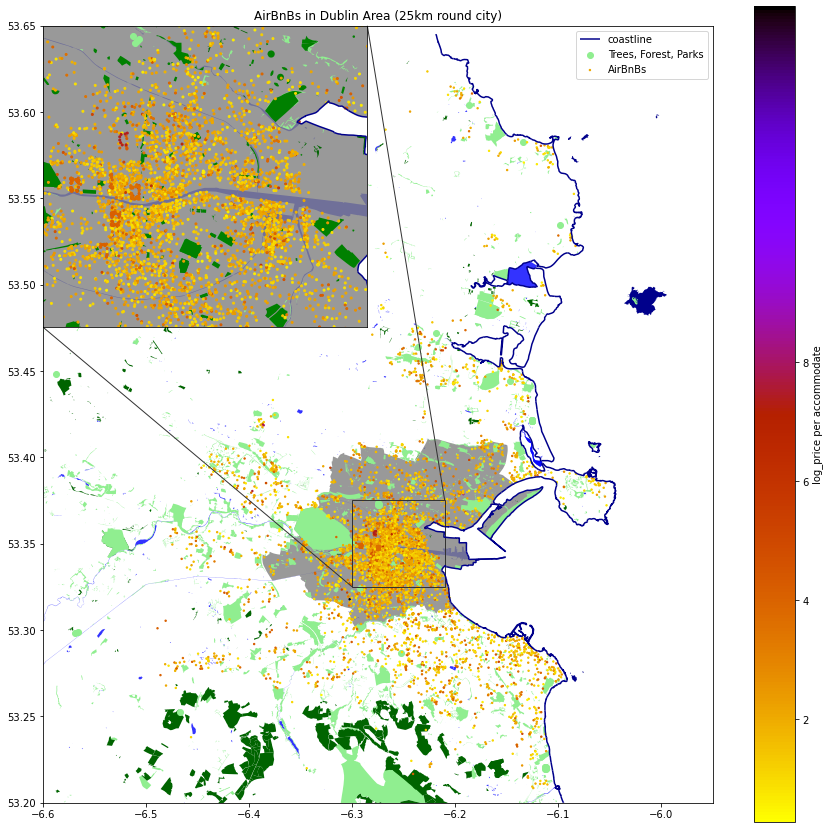

In [10]:
dublin_area_gdf = ox.geocode_to_gdf("Dublin, County Dublin, Leinster, Ireland", buffer_dist=25000)
dublin_gdf = ox.geocode_to_gdf("Dublin, County Dublin, Leinster, Ireland")

plotdf = gdf.merge(price)
plotdf["log_price_pP"] = plotdf["log_price"] / plotdf["accommodates"]
# Set up a plot axis
fig, ax = plt.subplots(figsize = (15,15))

# Visualise both on the plot
dublin_area_gdf.plot(ax = ax, alpha = 0.3, color = "white")
water_gdf.plot(ax=ax, color = "blue", alpha = 0.8, label = "water")
coastline_gdf.plot(ax=ax, color="darkblue", label ="coastline" )
dublin_gdf.plot(ax = ax, alpha = 0.8, color = "grey", label = 'Dublin City')
wood_gdf.plot(ax=ax, color ="lightgreen", alpha = 1, label = "Trees, Forest, Parks")
park_gdf.plot(ax=ax, color ="lightgreen", alpha = 1)
forest_gdf.plot(ax=ax, color ="darkgreen", alpha = 1, label ="forest")
parks_gdf.plot(ax=ax, color ="lightgreen", alpha = 1)#, label ="city parks")
#gdf.plot(ax = ax, markersize = 2, color = 'red', alpha = 0.8, label = 'AirBnBs')
plt.scatter(plotdf.longitude, plotdf.latitude, s = 2, c=plotdf["log_price_pP"], cmap="gnuplot_r", label = "AirBnBs")
plt.legend()
plt.title("AirBnBs in Dublin Area (25km round city)")
ax.set_xlim(-6.6, -5.95)
ax.set_ylim(53.2, 53.65)

plt.colorbar(location = "right", orientation = "vertical", 
                label = "log_price per accommodate", ticks=range(0, 10, 2))

# Subplot
#Defines the size of the zoom window and the positioning
axins = inset_axes(ax, 4.5, 4.5, loc = 1, bbox_to_anchor=(0.43, 0.877),
                   bbox_transform = ax.figure.transFigure)

dublin_area_gdf.plot(ax = axins, alpha = 0.3, color = "white")
water_gdf.plot(ax=axins, color = "blue", alpha = 0.8, label = "water")
coastline_gdf.plot(ax=axins, color="darkblue", label ="coastline" )
dublin_gdf.plot(ax = axins, alpha = 0.8, color = "grey", label = 'Dublin City')
wood_gdf.plot(ax=axins, color ="lightgreen", alpha = 1, label = "Trees, Forest, Parks")
park_gdf.plot(ax=axins, color ="lightgreen", alpha = 1)
forest_gdf.plot(ax=axins, color ="darkgreen", alpha = 1, label ="forest")
parks_gdf.plot(ax=axins, color ="green", alpha = 1)#, label ="city parks")
#gdf.plot(ax = axins, markersize = 2, color = 'red', alpha = 0.8, label = 'AirBnBs')
plt.scatter(plotdf.longitude, plotdf.latitude, s = 4, c=plotdf["log_price_pP"], cmap="gnuplot_r", label = "AirBnBs")


x1, x2 = -6.3, -6.21
y1, y2 = 53.325, 53.375

#Setting the limit of x and y direction to define which portion to #zoom
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticks([])
axins.set_yticks([])
#Draw the lines from the portion to zoom and the zoom window
mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec = "0.2")


plt.savefig("AirBnB_in_Dublin")


# First OSM-Data from map

In [11]:
# in city?
listings_osm["in_city"] = gdf["geometry"].apply(lambda x: dublin_gdf.geometry.contains(x))

(53.2, 53.64)

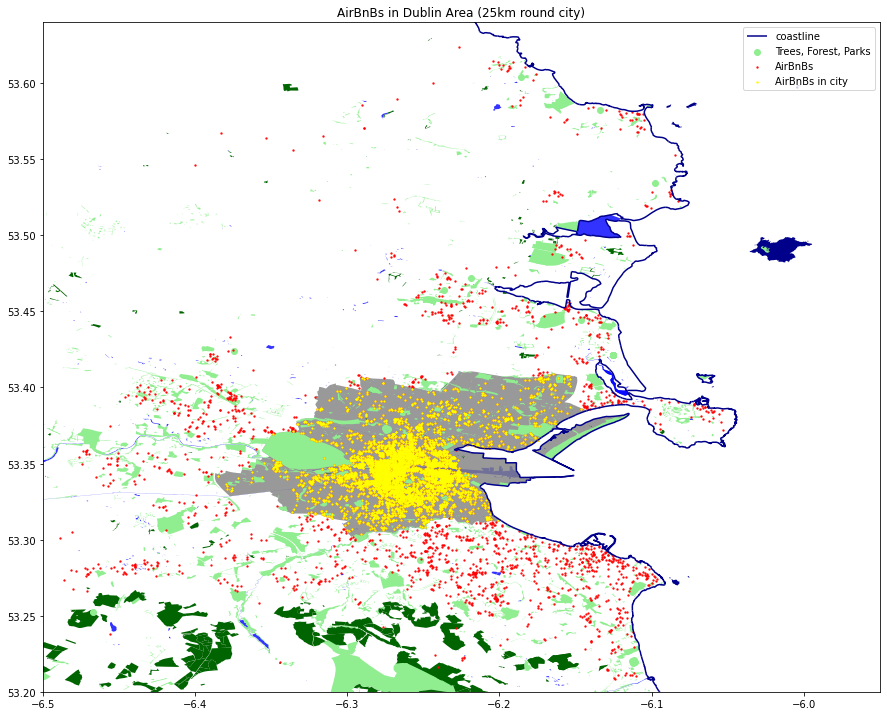

In [12]:
# Did that work?

gdf_city = gdf.loc[listings_osm["in_city"].values]

dublin_area_gdf = ox.geocode_to_gdf("Dublin, County Dublin, Leinster, Ireland", buffer_dist=25000)
dublin_gdf = ox.geocode_to_gdf("Dublin, County Dublin, Leinster, Ireland")
# Set up a plot axis
fig, ax = plt.subplots(figsize = (15,15))

# Visualise both on the plot
dublin_area_gdf.plot(ax = ax, alpha = 0.3, color = "white")
water_gdf.plot(ax=ax, color = "blue", alpha = 0.8, label = "water")
coastline_gdf.plot(ax=ax, color="darkblue", label ="coastline" )
dublin_gdf.plot(ax = ax, alpha = 0.8, color = "grey", label = 'Dublin City')
wood_gdf.plot(ax=ax, color ="lightgreen", alpha = 1, label = "Trees, Forest, Parks")
park_gdf.plot(ax=ax, color ="lightgreen", alpha = 1)
forest_gdf.plot(ax=ax, color ="darkgreen", alpha = 1, label ="forest")
parks_gdf.plot(ax=ax, color ="lightgreen", alpha = 1)#, label ="city parks")
gdf.plot(ax = ax, markersize = 2, color = 'red', alpha = 0.8, label = 'AirBnBs')
gdf_city.plot(ax = ax, markersize = 2, color = 'yellow', alpha = 1, label = 'AirBnBs in city')
plt.legend()
plt.title("AirBnBs in Dublin Area (25km round city)")
ax.set_xlim(-6.5, -5.95)
ax.set_ylim(53.2, 53.64)

In [13]:
listings_osm["in_city"] = listings_osm["in_city"].astype(int)

# Number of anemities in 10 minute walk

first needed functions and coords

In [14]:
# The earth is round, that is why we need to convert coordinates into local projections

def get_local_crs(y,x):  
    x = ox.utils_geo.bbox_from_point((y, x), dist = 25000, project_utm = True, return_crs = True)
    return x[-1]

def find_points_closeby(lat_lon, k = 500, max_distance = 1000):
  
  results = tree.query((lat_lon), k = k, distance_upper_bound= max_distance)
  zipped_results = list(zip(results[0], results[1]))
  zipped_results = [i for i in zipped_results if i[0] != np.inf]
  
  return len(zipped_results)
  
# Set Dublin longitude and latitude
lon_latitude = 53.3467
lon_longitude = -6.2591

local_utm_crs = get_local_crs(lon_latitude, lon_longitude)

air_gdf = geopandas.GeoDataFrame(listings, geometry = geopandas.points_from_xy(listings.longitude, listings.latitude), crs = 4326)
air_gdf = air_gdf.to_crs(local_utm_crs)

## Sustenances

look here: https://wiki.openstreetmap.org/wiki/Map_features#Facilities

In [15]:
# Set up query
query = {'amenity': "bar"}

#Run query, # does not work
bar_gdf = ox.geometries_from_place(
            "Dublin, County Dublin, Leinster, Ireland",
            tags = query,
            which_result=1,
            buffer_dist=25000)

bar_gdf['geometry'] = bar_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
bar_gdf['geometry'] = bar_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
bar_gdf = bar_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = bar_gdf.geometry.apply(lambda x: x.x).values
Lat = bar_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['bars'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

In [16]:
# Set up query
query = {'amenity': "biergarten"}

#Run query, # does not work
biergarten_gdf = ox.geometries_from_place(
            "Dublin, County Dublin, Leinster, Ireland",
            tags = query,
            which_result=1,
            buffer_dist=25000)

biergarten_gdf['geometry'] = biergarten_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
biergarten_gdf['geometry'] = biergarten_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
biergarten_gdf = biergarten_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = biergarten_gdf.geometry.apply(lambda x: x.x).values
Lat = biergarten_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['biergarten'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

In [17]:
# Set up query
query = {'amenity': "cafe"}

#Run query, # does not work
cafe_gdf = ox.geometries_from_place(
            "Dublin, County Dublin, Leinster, Ireland",
            tags = query,
            which_result=1,
            buffer_dist=25000)

cafe_gdf['geometry'] = cafe_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
cafe_gdf['geometry'] = cafe_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
cafe_gdf = cafe_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = cafe_gdf.geometry.apply(lambda x: x.x).values
Lat = cafe_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['cafes'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

In [18]:
# Set up query
query = {'amenity': "fast_food"}

#Run query, # does not work
fast_food_gdf = ox.geometries_from_place(
            "Dublin, County Dublin, Leinster, Ireland",
            tags = query,
            which_result=1,
            buffer_dist=25000)

fast_food_gdf['geometry'] = fast_food_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
fast_food_gdf['geometry'] = fast_food_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
fast_food_gdf = fast_food_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = fast_food_gdf.geometry.apply(lambda x: x.x).values
Lat = fast_food_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['fast_foods'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

In [19]:
# Set up query
query = {'amenity': "food_court"}

#Run query, # does not work
food_court_gdf = ox.geometries_from_place(
            "Dublin, County Dublin, Leinster, Ireland",
            tags = query,
            which_result=1,
            buffer_dist=25000)

food_court_gdf['geometry'] = food_court_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
food_court_gdf['geometry'] = food_court_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
food_court_gdf = food_court_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = food_court_gdf.geometry.apply(lambda x: x.x).values
Lat = food_court_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['food_courts'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

In [20]:
# Set up query
query = {'amenity': "pub"}

#Run query, # does not work
pub_gdf = ox.geometries_from_place(
            "Dublin, County Dublin, Leinster, Ireland",
            tags = query,
            which_result=1,
            buffer_dist=25000)

pub_gdf['geometry'] = pub_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
pub_gdf['geometry'] = pub_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
pub_gdf = pub_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = pub_gdf.geometry.apply(lambda x: x.x).values
Lat = pub_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['pubs'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

In [21]:
# Set up query
query = {'amenity': "restaurant"}

#Run query, # does not work
restaurant_gdf = ox.geometries_from_place(
            "Dublin, County Dublin, Leinster, Ireland",
            tags = query,
            which_result=1,
            buffer_dist=25000)

restaurant_gdf['geometry'] = restaurant_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
restaurant_gdf['geometry'] = restaurant_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
restaurant_gdf = restaurant_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = restaurant_gdf.geometry.apply(lambda x: x.x).values
Lat = restaurant_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['restaurants'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

array([[<AxesSubplot:title={'center':'in_city'}>,
        <AxesSubplot:title={'center':'bars'}>,
        <AxesSubplot:title={'center':'biergarten'}>],
       [<AxesSubplot:title={'center':'cafes'}>,
        <AxesSubplot:title={'center':'fast_foods'}>,
        <AxesSubplot:title={'center':'food_courts'}>],
       [<AxesSubplot:title={'center':'pubs'}>,
        <AxesSubplot:title={'center':'restaurants'}>, <AxesSubplot:>]],
      dtype=object)

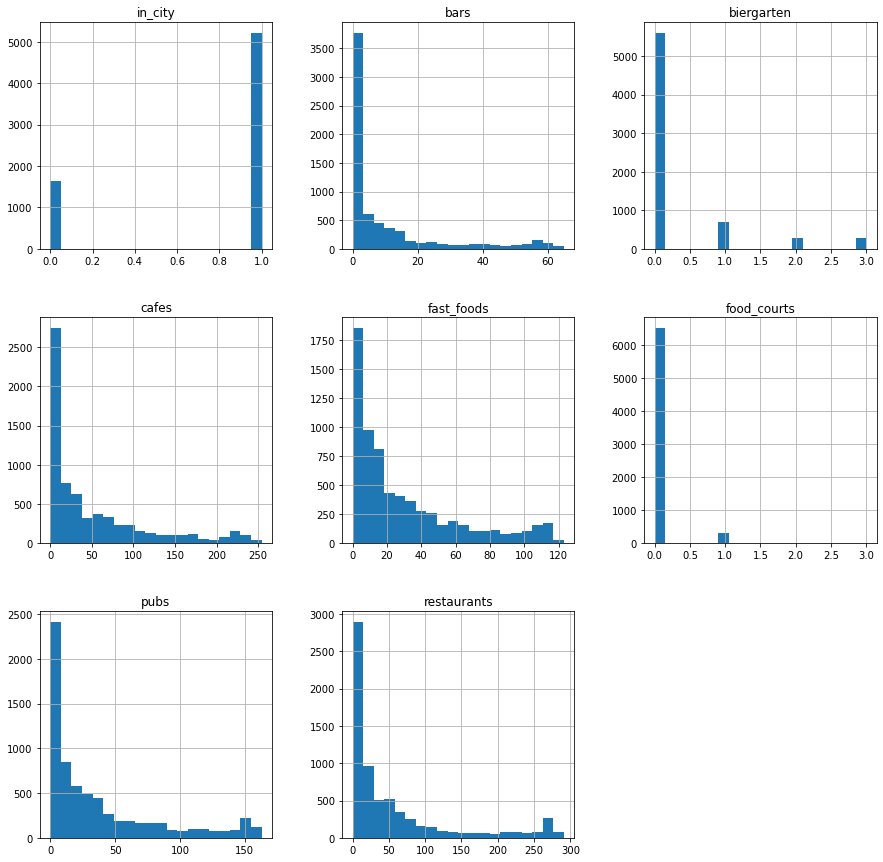

In [22]:
listings_osm[['in_city', 'bars', 'biergarten', 'cafes', 'fast_foods',
       'food_courts', 'pubs', 'restaurants']].hist(figsize=(15,15), bins = 20)

<AxesSubplot:>

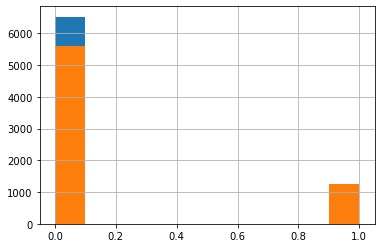

In [23]:
listings_osm["food_courts"] = (listings_osm["food_courts"] > 0).astype(int)
listings_osm["biergarten"] = (listings_osm["biergarten"] > 0).astype(int)
listings_osm["food_courts"].hist()
listings_osm["biergarten"].hist()

## Education

In [24]:
# Set up query
query = {'amenity': "college"}

#Run query, # does not work
college_gdf = ox.geometries_from_place(
            "Dublin, County Dublin, Leinster, Ireland",
            tags = query,
            which_result=1,
            buffer_dist=25000)

college_gdf['geometry'] = college_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
college_gdf['geometry'] = college_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
college_gdf = college_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = college_gdf.geometry.apply(lambda x: x.x).values
Lat = college_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['college'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

In [25]:
# Set up query
query = {'amenity': "library"}

#Run query, # does not work
library_gdf = ox.geometries_from_place(
            "Dublin, County Dublin, Leinster, Ireland",
            tags = query,
            which_result=1,
            buffer_dist=25000)

library_gdf['geometry'] = library_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
library_gdf['geometry'] = library_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
library_gdf = library_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = library_gdf.geometry.apply(lambda x: x.x).values
Lat = library_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['library'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

In [26]:
# Set up query
query = {'amenity': "university"}

#Run query, # does not work
university_gdf = ox.geometries_from_place(
            "Dublin, County Dublin, Leinster, Ireland",
            tags = query,
            which_result=1,
            buffer_dist=25000)

university_gdf['geometry'] = university_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
university_gdf['geometry'] = university_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
university_gdf = university_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = university_gdf.geometry.apply(lambda x: x.x).values
Lat = university_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['university'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

array([[<AxesSubplot:title={'center':'college'}>,
        <AxesSubplot:title={'center':'library'}>],
       [<AxesSubplot:title={'center':'university'}>, <AxesSubplot:>]],
      dtype=object)

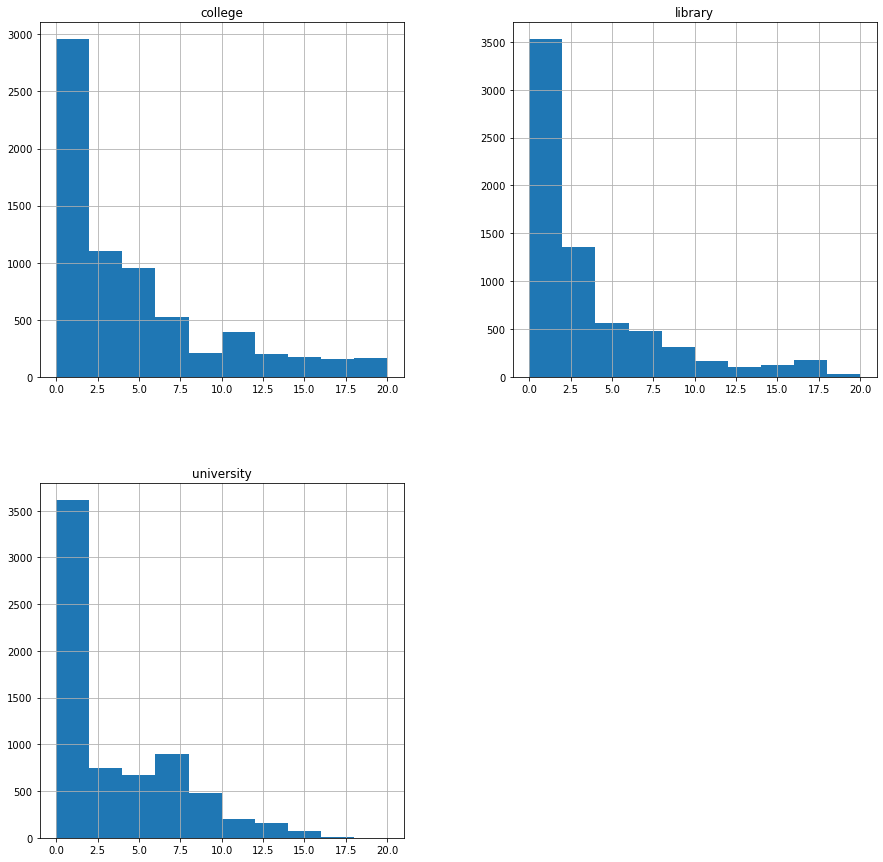

In [27]:
listings_osm[["college", "library", "university"]].hist(figsize=(15,15), bins = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20])

## Transportation

In [28]:
# Set up query
query = {'railway': "halt"}

#Run query, # does not work
small_station_gdf = ox.geometries_from_place(
            "Dublin, County Dublin, Leinster, Ireland",
            tags = query,
            which_result=1,
            buffer_dist=25000)

small_station_gdf['geometry'] = small_station_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
small_station_gdf['geometry'] = small_station_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
small_station_gdf = small_station_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = small_station_gdf.geometry.apply(lambda x: x.x).values
Lat = small_station_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['small_stations'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

In [29]:
# Set up query
query = {'public_transport': "station"}

#Run query, # does not work
station_gdf = ox.geometries_from_place(
            "Dublin, County Dublin, Leinster, Ireland",
            tags = query,
            which_result=1,
            buffer_dist=25000)

station_gdf['geometry'] = station_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
station_gdf['geometry'] = station_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
station_gdf = station_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = station_gdf.geometry.apply(lambda x: x.x).values
Lat = station_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['stations'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

In [30]:
# Set up query
query = {'railway': "tram_stop"}

#Run query, # does not work
tram_stop_gdf = ox.geometries_from_place(
            "Dublin, County Dublin, Leinster, Ireland",
            tags = query,
            which_result=1,
            buffer_dist=25000)

tram_stop_gdf['geometry'] = tram_stop_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
tram_stop_gdf['geometry'] = tram_stop_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
tram_stop_gdf = tram_stop_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = tram_stop_gdf.geometry.apply(lambda x: x.x).values
Lat = tram_stop_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['tram_stops'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

In [31]:
# Set up query
query = {'amenity': "bicycle_rental"}

#Run query, # does not work
bicycle_rental_gdf = ox.geometries_from_place(
            "Dublin, County Dublin, Leinster, Ireland",
            tags = query,
            which_result=1,
            buffer_dist=25000)

bicycle_rental_gdf['geometry'] = bicycle_rental_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
bicycle_rental_gdf['geometry'] = bicycle_rental_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
bicycle_rental_gdf = bicycle_rental_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = bicycle_rental_gdf.geometry.apply(lambda x: x.x).values
Lat = bicycle_rental_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['bicycle_rentals'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

In [32]:
# Set up query
query = {'amenity': "bus_station"}

#Run query, # does not work
bus_station_gdf = ox.geometries_from_place(
            "Dublin, County Dublin, Leinster, Ireland",
            tags = query,
            which_result=1,
            buffer_dist=25000)

bus_station_gdf['geometry'] = bus_station_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
bus_station_gdf['geometry'] = bus_station_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
bus_station_gdf = bus_station_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = bus_station_gdf.geometry.apply(lambda x: x.x).values
Lat = bus_station_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['bus_stations'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

In [33]:
# Set up query
query = {'amenity': "ferry_terminal"}

#Run query, # does not work
ferry_terminal_gdf = ox.geometries_from_place(
            "Dublin, County Dublin, Leinster, Ireland",
            tags = query,
            which_result=1,
            buffer_dist=25000)

ferry_terminal_gdf['geometry'] = ferry_terminal_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
ferry_terminal_gdf['geometry'] = ferry_terminal_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
ferry_terminal_gdf = ferry_terminal_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = ferry_terminal_gdf.geometry.apply(lambda x: x.x).values
Lat = ferry_terminal_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['ferry_terminal'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

In [34]:
# Set up query
query = {'amenity': "parking"}

#Run query, # does not work
parking_gdf = ox.geometries_from_place(
            "Dublin, County Dublin, Leinster, Ireland",
            tags = query,
            which_result=1,
            buffer_dist=25000)

parking_gdf['geometry'] = parking_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
parking_gdf['geometry'] = parking_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
parking_gdf = parking_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = parking_gdf.geometry.apply(lambda x: x.x).values
Lat = parking_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['parking'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

In [35]:
# Set up query
query = {'amenity': "taxi"}

#Run query, # does not work
taxi_gdf = ox.geometries_from_place(
            "Dublin, County Dublin, Leinster, Ireland",
            tags = query,
            which_result=1,
            buffer_dist=25000)

taxi_gdf['geometry'] = taxi_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
taxi_gdf['geometry'] = taxi_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
taxi_gdf = taxi_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = taxi_gdf.geometry.apply(lambda x: x.x).values
Lat = taxi_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['taxi'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

array([[<AxesSubplot:title={'center':'small_stations'}>,
        <AxesSubplot:title={'center':'stations'}>,
        <AxesSubplot:title={'center':'tram_stops'}>],
       [<AxesSubplot:title={'center':'bicycle_rentals'}>,
        <AxesSubplot:title={'center':'bus_stations'}>,
        <AxesSubplot:title={'center':'ferry_terminal'}>],
       [<AxesSubplot:title={'center':'parking'}>,
        <AxesSubplot:title={'center':'taxi'}>, <AxesSubplot:>]],
      dtype=object)

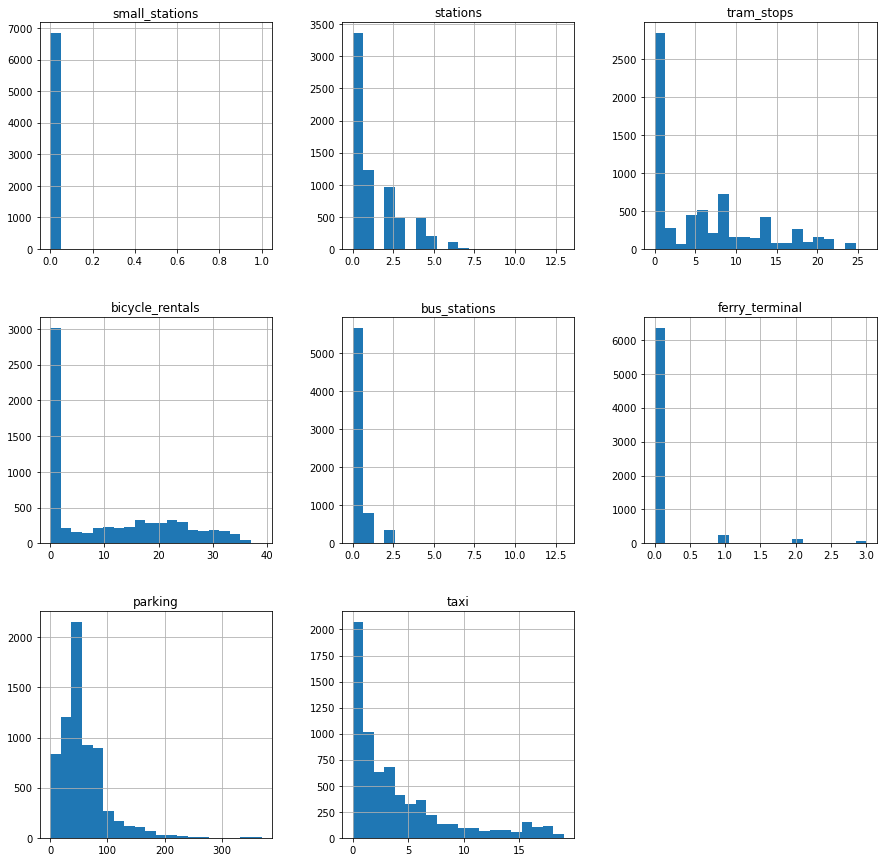

In [36]:
listings_osm[['small_stations', 'stations', 'tram_stops',
       'bicycle_rentals', 'bus_stations', 'ferry_terminal', 'parking', 'taxi']].hist(bins = 20, figsize=(15,15))

array([[<AxesSubplot:title={'center':'ferry_terminal'}>,
        <AxesSubplot:title={'center':'bus_station'}>]], dtype=object)

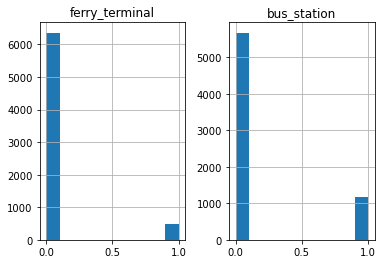

In [37]:
listings_osm["ferry_terminal"] = (listings_osm["ferry_terminal"] > 0).astype(int)
listings_osm["bus_station"] = (listings_osm["bus_stations"] > 0).astype(int)
del listings_osm["bus_stations"]
del listings_osm["small_stations"]

listings_osm[["ferry_terminal", "bus_station"]].hist()

## Entertainment, Arts & Culture

In [38]:
# Set up query
query = {'amenity': "arts_centre"}

#Run query, # does not work
arts_centre_gdf = ox.geometries_from_place(
            "Dublin, County Dublin, Leinster, Ireland",
            tags = query,
            which_result=1,
            buffer_dist=25000)

arts_centre_gdf['geometry'] = arts_centre_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
arts_centre_gdf['geometry'] = arts_centre_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
arts_centre_gdf = arts_centre_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = arts_centre_gdf.geometry.apply(lambda x: x.x).values
Lat = arts_centre_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['arts_centres'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

In [39]:
# Set up query
query = {'amenity': "casino"}

#Run query, # does not work
casino_gdf = ox.geometries_from_place(
            "Dublin, County Dublin, Leinster, Ireland",
            tags = query,
            which_result=1,
            buffer_dist=25000)

casino_gdf['geometry'] = casino_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
casino_gdf['geometry'] = casino_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
casino_gdf = casino_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = casino_gdf.geometry.apply(lambda x: x.x).values
Lat = casino_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['casinos'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

In [40]:
# Set up query
query = {'amenity': "cinema"}

#Run query, # does not work
cinema_gdf = ox.geometries_from_place(
            "Dublin, County Dublin, Leinster, Ireland",
            tags = query,
            which_result=1,
            buffer_dist=25000)

cinema_gdf['geometry'] = cinema_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
cinema_gdf['geometry'] = cinema_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
cinema_gdf = cinema_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = cinema_gdf.geometry.apply(lambda x: x.x).values
Lat = cinema_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['cinemas'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

In [41]:
# Set up query
query = {'amenity': "nightclub"}

#Run query, # does not work
nightclub_gdf = ox.geometries_from_place(
            "Dublin, County Dublin, Leinster, Ireland",
            tags = query,
            which_result=1,
            buffer_dist=25000)

nightclub_gdf['geometry'] = nightclub_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
nightclub_gdf['geometry'] = nightclub_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
nightclub_gdf = nightclub_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = nightclub_gdf.geometry.apply(lambda x: x.x).values
Lat = nightclub_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['nightclubs'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

In [42]:
# Set up query
query = {'amenity': ["social_centre", "public_bookcase", "community_centre"]}

#Run query, # does not work
social_amenities_gdf = ox.geometries_from_place(
            "Dublin, County Dublin, Leinster, Ireland",
            tags = query,
            which_result=1,
            buffer_dist=25000)

social_amenities_gdf['geometry'] = social_amenities_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
social_amenities_gdf['geometry'] = social_amenities_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
social_amenities_gdf = social_amenities_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = social_amenities_gdf.geometry.apply(lambda x: x.x).values
Lat = social_amenities_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['social_amenities'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

In [43]:
# Set up query
query = {'amenity': ["stripclub", "swingerclub", "love_hotel", "brothel"]}

#Run query, # does not work
sex_amenities_gdf = ox.geometries_from_place(
            "Dublin, County Dublin, Leinster, Ireland",
            tags = query,
            which_result=1,
            buffer_dist=25000)

sex_amenities_gdf['geometry'] = sex_amenities_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
sex_amenities_gdf['geometry'] = sex_amenities_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
sex_amenities_gdf = sex_amenities_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = sex_amenities_gdf.geometry.apply(lambda x: x.x).values
Lat = sex_amenities_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['sex_amenities'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

In [44]:
# Set up query
query = {'amenity': "theatre"}

#Run query, # does not work
theatre_gdf = ox.geometries_from_place(
            "Dublin, County Dublin, Leinster, Ireland",
            tags = query,
            which_result=1,
            buffer_dist=25000)

theatre_gdf['geometry'] = theatre_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
theatre_gdf['geometry'] = theatre_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
theatre_gdf = theatre_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = theatre_gdf.geometry.apply(lambda x: x.x).values
Lat = theatre_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['theatres'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

array([[<AxesSubplot:title={'center':'arts_centres'}>,
        <AxesSubplot:title={'center':'casinos'}>,
        <AxesSubplot:title={'center':'cinemas'}>],
       [<AxesSubplot:title={'center':'nightclubs'}>,
        <AxesSubplot:title={'center':'social_amenities'}>,
        <AxesSubplot:title={'center':'sex_amenities'}>],
       [<AxesSubplot:title={'center':'theatres'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

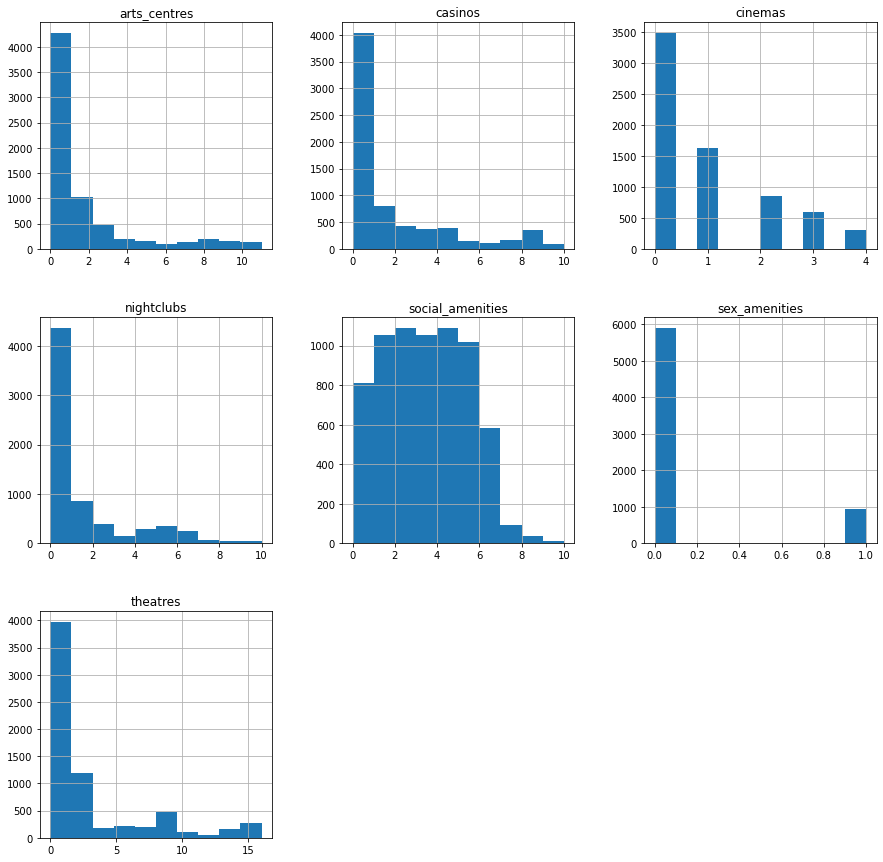

In [45]:
listings_osm[['arts_centres',
       'casinos', 'cinemas', 'nightclubs', 'social_amenities', 'sex_amenities',
       'theatres']].hist(figsize = (15,15), bins = 10)

# Commercials

In [46]:
# Set up query
query = {'shop': "mall"}

#Run query, # does not work
mall_gdf = ox.geometries_from_place(
            "Dublin, County Dublin, Leinster, Ireland",
            tags = query,
            which_result=1,
            buffer_dist=25000)

mall_gdf['geometry'] = mall_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
mall_gdf['geometry'] = mall_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
mall_gdf = mall_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = mall_gdf.geometry.apply(lambda x: x.x).values
Lat = mall_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['malls'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

In [47]:
# Set up query
query = {'building': "kiosk", "shop": "kiosk"}

#Run query, # does not work
kiosk_gdf = ox.geometries_from_place(
            "Dublin, County Dublin, Leinster, Ireland",
            tags = query,
            which_result=1,
            buffer_dist=25000)

kiosk_gdf['geometry'] = kiosk_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
kiosk_gdf['geometry'] = kiosk_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
kiosk_gdf = kiosk_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = kiosk_gdf.geometry.apply(lambda x: x.x).values
Lat = kiosk_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['kiosks'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

In [48]:
# Set up query
query = {'building': "supermarket", "shop": "supermarket"}

#Run query, # does not work
supermarket_gdf = ox.geometries_from_place(
            "Dublin, County Dublin, Leinster, Ireland",
            tags = query,
            which_result=1,
            buffer_dist=25000)

supermarket_gdf['geometry'] = supermarket_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x)
)

# needed this, too
supermarket_gdf['geometry'] = supermarket_gdf['geometry'].apply(
  lambda x: x.centroid if type(x) == LineString else x)


#Convert amenities into local projection (amenities already had an initial CRS set when we downloaded it via OSMnx)
supermarket_gdf = supermarket_gdf.to_crs(local_utm_crs)

# Turn long/lats into an array for Scipy
Lon = supermarket_gdf.geometry.apply(lambda x: x.x).values
Lat = supermarket_gdf.geometry.apply(lambda x: x.y).values
coords = list(zip(Lat,Lon))

tree = spatial.KDTree(coords) # Create a KDTree of all tube stations


#Apply the function
listings_osm['supermarkets'] = air_gdf.apply(lambda row: find_points_closeby(
  (row.geometry.y, row.geometry.x)) , axis = 1)

array([[<AxesSubplot:title={'center':'malls'}>,
        <AxesSubplot:title={'center':'kiosks'}>],
       [<AxesSubplot:title={'center':'supermarkets'}>, <AxesSubplot:>]],
      dtype=object)

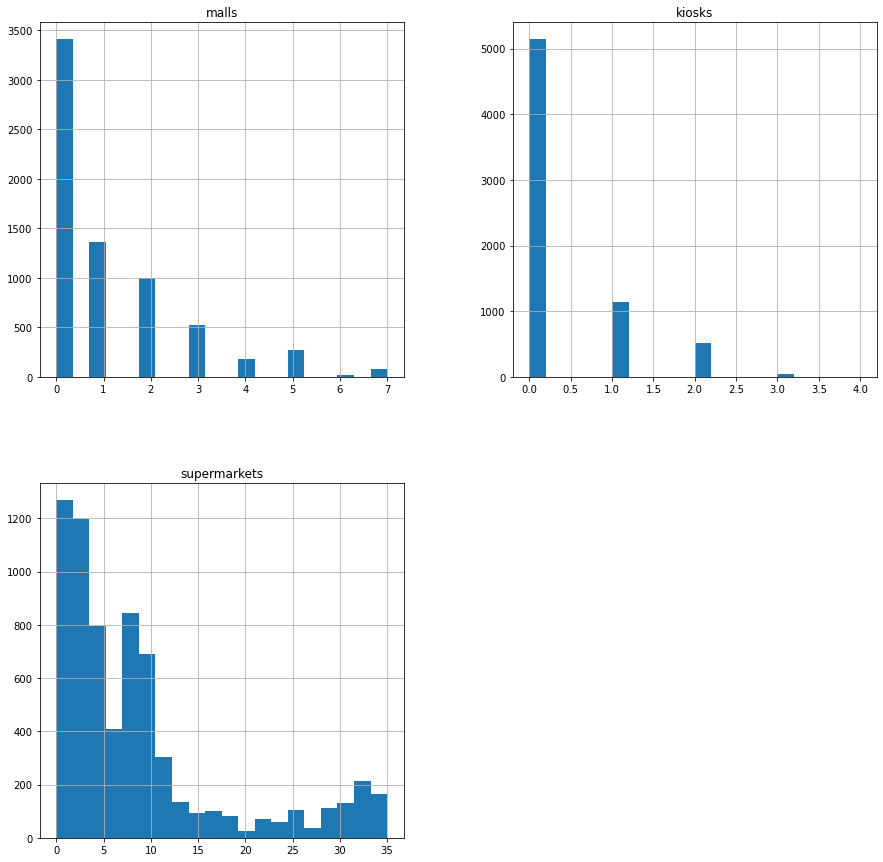

In [49]:
listings_osm[["malls", "kiosks", "supermarkets"]].hist(figsize = (15,15), bins = 20)

# Distances

https://github.com/QuangTrungNguyen/Airbnb-pricing-prediction/blob/master/exploratory-data-analysis/Exploratory%20Data%20Analysis.ipynb
Top10 from Tripadvisor + TempleBar + Airport + Main station + Harbour

In [50]:
# Set up Api

geolocator = geopy.geocoders.Nominatim(user_agent="1241ae50-7544-11ec-89e4-27bc646f8191")

In [51]:
# Geodata
Temple_Bar = (geolocator.geocode("Temple Bar, Dublin").latitude, geolocator.geocode("Temple Bar, Dublin").longitude) 
Jameson_Distillery = (geolocator.geocode("Jameson Distillery, Dublin").latitude, geolocator.geocode("Jameson Distillery, Dublin").longitude)
Irish_Whiskey_Museum = (geolocator.geocode("Irish Whiskey Museum, Dublin").latitude, geolocator.geocode("Irish Whiskey Museum, Dublin").longitude)
EPIC_Irish_Emigration = (geolocator.geocode("EPIC Irish Emigration Museum, Dublin").latitude, geolocator.geocode("EPIC Irish Emigration Museum, Dublin").longitude)
Little_Museum_Dublin = (geolocator.geocode("Little Museum, Dublin").latitude, geolocator.geocode("Little Museum, Dublin").longitude) 
Kilmainham_Gaol = (geolocator.geocode("Kilmainham Gaol, Dublin").latitude, geolocator.geocode("Kilmainham Gaol, Dublin").longitude) 
Teeling_Whiskey = (geolocator.geocode("Teeling Whiskey Distillery, Dublin").latitude, geolocator.geocode("Teeling Whiskey Distillery, Dublin").longitude) 
Glasnevin_cemetery = (geolocator.geocode("Glasnevin Cemetery, Dublin").latitude, geolocator.geocode("Glasnevin Cemetery, Dublin").longitude) 
Trinity_College = (geolocator.geocode("Trinity College, Dublin").latitude, geolocator.geocode("Trinity College, Dublin").longitude) 
Guinnes_Storehouse = (geolocator.geocode("Guinness Storehouse, Dublin").latitude, geolocator.geocode("Guinness Storehouse, Dublin").longitude) 
National_Museum = (geolocator.geocode("National Museum of Ireland, Dublin").latitude, geolocator.geocode("National Museum of Ireland, Dublin").longitude) 

Airport = (geolocator.geocode("Airport, Dublin").latitude, geolocator.geocode("Airport, Dublin").longitude) 
heuston_station = (geolocator.geocode("Heuston Station, Dublin").latitude, geolocator.geocode("Heuston Station, Dublin").longitude) 
docks = (geolocator.geocode("Dublin Port (Terminal 5)").latitude, geolocator.geocode("Dublin Port (Terminal 5)").longitude) 

(53.32, 53.38)

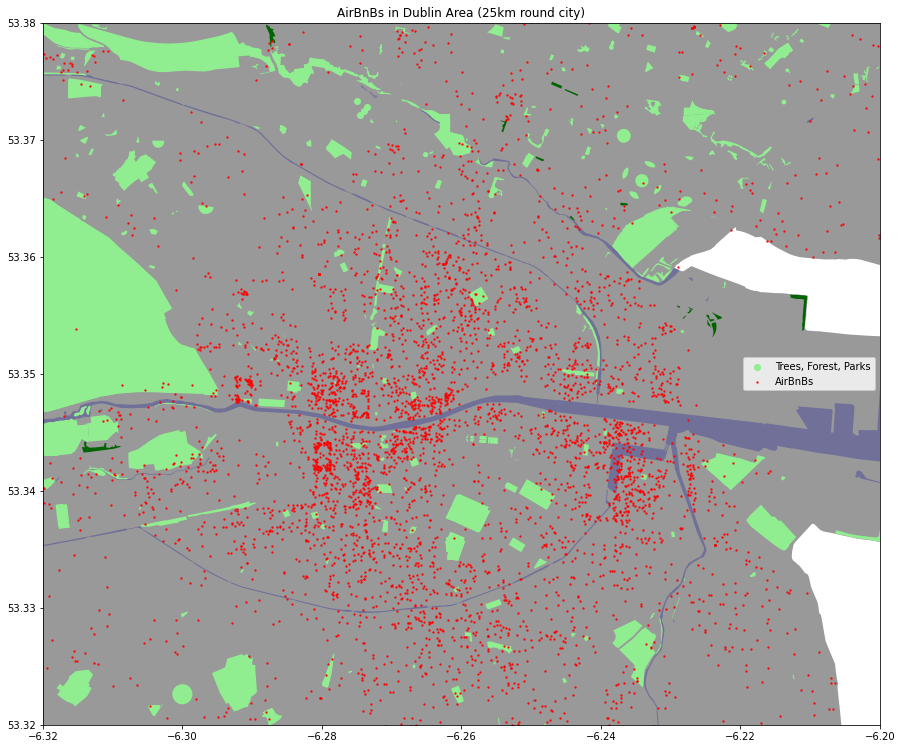

In [52]:
# Try to plot those location into the city, but does not work

gdf_city = gdf.loc[listings_osm["in_city"].values]

dublin_area_gdf = ox.geocode_to_gdf("Dublin, County Dublin, Leinster, Ireland", buffer_dist=25000)
dublin_gdf = ox.geocode_to_gdf("Dublin, County Dublin, Leinster, Ireland")
# Set up a plot axis
fig, ax = plt.subplots(figsize = (15,15))

# Visualise both on the plot
dublin_area_gdf.plot(ax = ax, alpha = 0.3, color = "white")
water_gdf.plot(ax=ax, color = "blue", alpha = 0.8, label = "water")
#coastline_gdf.plot(ax=ax, color="darkblue", label ="coastline" )
dublin_gdf.plot(ax = ax, alpha = 0.8, color = "grey", label = 'Dublin City')
wood_gdf.plot(ax=ax, color ="lightgreen", alpha = 1, label = "Trees, Forest, Parks")
park_gdf.plot(ax=ax, color ="lightgreen", alpha = 1)
forest_gdf.plot(ax=ax, color ="darkgreen", alpha = 1, label ="forest")
parks_gdf.plot(ax=ax, color ="lightgreen", alpha = 1)#, label ="city parks")
gdf.plot(ax = ax, markersize = 2, color = 'red', alpha = 0.8, label = 'AirBnBs')

# here
plt.scatter(Temple_Bar[0], Temple_Bar[1], marker="p", c = "magenta", s=5000)



plt.legend()
plt.title("AirBnBs in Dublin Area (25km round city)")
ax.set_xlim(-6.32, -6.2)
ax.set_ylim(53.32, 53.38)

In [53]:
for index, row in listings.iterrows():
    coords = (row['latitude'], row['longitude'])

    # Sights
    dist_Temple_Bar = geopy.distance.geodesic(Temple_Bar, coords).m
    dist_Jameson_Distillery = geopy.distance.geodesic(Jameson_Distillery, coords).m
    dist_Irish_Whiskey_Museum = geopy.distance.geodesic(Irish_Whiskey_Museum, coords).m
    dist_EPIC_Irish_Emigration = geopy.distance.geodesic(EPIC_Irish_Emigration, coords).m
    dist_Little_Museum_Dublin = geopy.distance.geodesic(Little_Museum_Dublin, coords).m
    dist_Kilmainham_Gaol = geopy.distance.geodesic(Kilmainham_Gaol, coords).m
    dist_Teeling_Whiskey = geopy.distance.geodesic(Teeling_Whiskey, coords).m
    dist_Glasnevin_cemetery = geopy.distance.geodesic(Glasnevin_cemetery, coords).m
    dist_Trinity_College = geopy.distance.geodesic(Trinity_College, coords).m
    dist_Guinnes_Storehouse = geopy.distance.geodesic(Guinnes_Storehouse, coords).m
    dist_National_Museum = geopy.distance.geodesic(National_Museum, coords).m

    #Travel locations
    dist_Airport = geopy.distance.geodesic(Airport, coords).m
    dist_heuston_station = geopy.distance.geodesic(heuston_station, coords).m
    dist_docks = geopy.distance.geodesic(docks, coords).m

    nearest_sight = min(dist_Temple_Bar, dist_Jameson_Distillery, dist_Irish_Whiskey_Museum, dist_EPIC_Irish_Emigration,
                        dist_Little_Museum_Dublin, dist_Kilmainham_Gaol, dist_Teeling_Whiskey, dist_Glasnevin_cemetery,
                        dist_Trinity_College, dist_Guinnes_Storehouse, dist_National_Museum)
    
    mean_dist_sight = mean([dist_Temple_Bar, dist_Jameson_Distillery, dist_Irish_Whiskey_Museum, dist_EPIC_Irish_Emigration,
                        dist_Little_Museum_Dublin, dist_Kilmainham_Gaol, dist_Teeling_Whiskey, dist_Glasnevin_cemetery,
                        dist_Trinity_College, dist_Guinnes_Storehouse, dist_National_Museum])

    nearest_travel_poss = min(dist_Airport, dist_heuston_station, dist_docks)

    mean_dist_travel = mean([dist_Airport, dist_heuston_station, dist_docks])

    listings_osm.at[index, 'dist_Temple_Bar'] = dist_Temple_Bar
    listings_osm.at[index, 'dist_Jameson_Distillery'] = dist_Jameson_Distillery
    listings_osm.at[index, 'dist_Irish_Whiskey_Museum'] = dist_Irish_Whiskey_Museum
    listings_osm.at[index, 'dist_EPIC_Irish_Emigration'] = dist_EPIC_Irish_Emigration
    listings_osm.at[index, 'dist_Little_Museum_Dublin'] = dist_Little_Museum_Dublin
    listings_osm.at[index, 'dist_Kilmainham_Gaol'] = dist_Kilmainham_Gaol
    listings_osm.at[index, 'dist_Teeling_Whiskey'] = dist_Teeling_Whiskey
    listings_osm.at[index, 'dist_Glasnevin_cemetery'] = dist_Glasnevin_cemetery
    listings_osm.at[index, 'dist_Trinity_College'] = dist_Trinity_College
    listings_osm.at[index, 'dist_Guinnes_Storehouse'] = dist_Guinnes_Storehouse
    listings_osm.at[index, 'dist_National_Museum'] = dist_National_Museum

    listings_osm.at[index, 'nearest_sight'] = nearest_sight
    listings_osm.at[index, 'mean_dist_sight'] = mean_dist_sight

    listings_osm.at[index, 'dist_Airport'] = dist_Airport
    listings_osm.at[index, 'dist_heuston_station'] = dist_heuston_station
    listings_osm.at[index, 'dist_docks'] = dist_docks

    listings_osm.at[index, 'nearest_travel_poss'] = nearest_travel_poss
    listings_osm.at[index, 'mean_dist_travel'] = mean_dist_travel

array([[<AxesSubplot:title={'center':'dist_Temple_Bar'}>,
        <AxesSubplot:title={'center':'dist_Jameson_Distillery'}>,
        <AxesSubplot:title={'center':'dist_Irish_Whiskey_Museum'}>,
        <AxesSubplot:title={'center':'dist_EPIC_Irish_Emigration'}>],
       [<AxesSubplot:title={'center':'dist_Little_Museum_Dublin'}>,
        <AxesSubplot:title={'center':'dist_Kilmainham_Gaol'}>,
        <AxesSubplot:title={'center':'dist_Teeling_Whiskey'}>,
        <AxesSubplot:title={'center':'dist_Glasnevin_cemetery'}>],
       [<AxesSubplot:title={'center':'dist_Trinity_College'}>,
        <AxesSubplot:title={'center':'dist_Guinnes_Storehouse'}>,
        <AxesSubplot:title={'center':'dist_National_Museum'}>,
        <AxesSubplot:title={'center':'nearest_sight'}>],
       [<AxesSubplot:title={'center':'mean_dist_sight'}>,
        <AxesSubplot:title={'center':'dist_Airport'}>,
        <AxesSubplot:title={'center':'dist_heuston_station'}>,
        <AxesSubplot:title={'center':'dist_docks'}>]

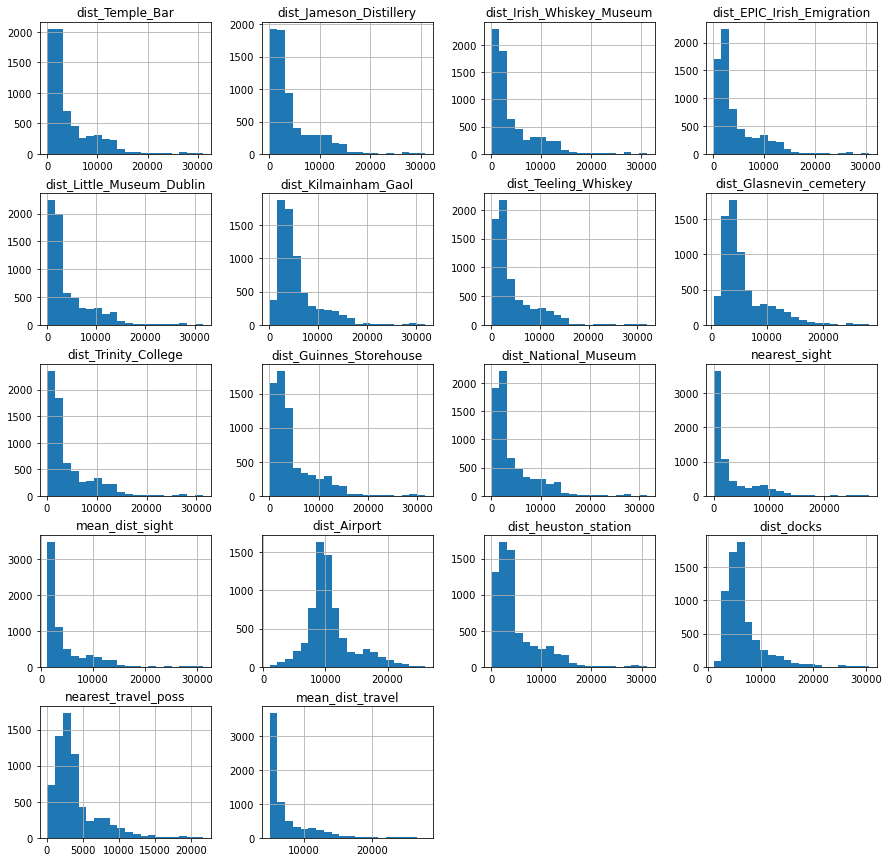

In [54]:
listings_osm[['dist_Temple_Bar',
       'dist_Jameson_Distillery', 'dist_Irish_Whiskey_Museum',
       'dist_EPIC_Irish_Emigration', 'dist_Little_Museum_Dublin',
       'dist_Kilmainham_Gaol', 'dist_Teeling_Whiskey',
       'dist_Glasnevin_cemetery', 'dist_Trinity_College',
       'dist_Guinnes_Storehouse', 'dist_National_Museum', 'nearest_sight',
       'mean_dist_sight', 'dist_Airport', 'dist_heuston_station', 'dist_docks',
       'nearest_travel_poss', 'mean_dist_travel']].hist(figsize = (15,15), bins = 20)

In [55]:
any(listings_osm.isna().sum() > 0)

False

# Correlations

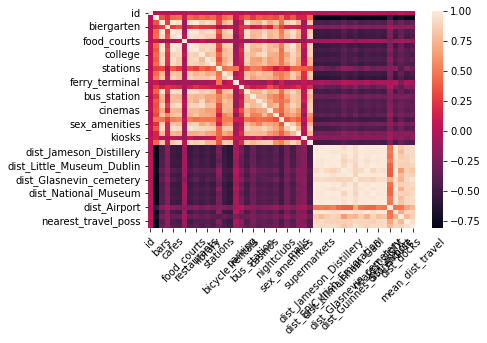

In [56]:
corr_mat = listings_osm.corr().round(2)
g = sns.heatmap(corr_mat)#, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag')
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment ="center")
plt.show()

In [57]:
# We see some high correlations
c = listings_osm.corr().abs()
# Set the diagonal to 0, so we do not look at self correlations
sol = (c.where(np.triu(np.ones(c.shape), k=1).astype(np.bool))
                  .stack()
                  .sort_values(ascending=False))

# Those destinations are quite close (see maps)
sol[sol > 0.9]

C:\Users\49173\anaconda3\envs\geo2\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


dist_Irish_Whiskey_Museum   dist_Trinity_College         0.999674
dist_Temple_Bar             dist_Irish_Whiskey_Museum    0.999056
dist_Little_Museum_Dublin   dist_National_Museum         0.998701
                            dist_Trinity_College         0.998079
dist_Temple_Bar             mean_dist_sight              0.997941
                                                           ...   
taxi                        theatres                     0.903541
dist_Temple_Bar             nearest_travel_poss          0.902295
dist_Kilmainham_Gaol        dist_National_Museum         0.902271
dist_EPIC_Irish_Emigration  dist_docks                   0.902175
dist_Little_Museum_Dublin   mean_dist_travel             0.901219
Length: 133, dtype: float64

In [58]:
listings_osm.head(10)

,id,in_city,bars,biergarten,cafes,fast_foods,food_courts,pubs,restaurants,college,...,dist_Trinity_College,dist_Guinnes_Storehouse,dist_National_Museum,nearest_sight,mean_dist_sight,dist_Airport,dist_heuston_station,dist_docks,nearest_travel_poss,mean_dist_travel
0,44077,0,0,0,5,9,0,4,9,1,...,5718.557809,5902.613355,5361.976549,5258.614042,6151.906435,15382.391103,6556.557064,7878.305870,6556.557064,9939.084679
1,85156,0,0,0,6,8,0,7,18,1,...,5684.880475,5907.566844,5322.302066,5253.646428,6133.229923,15341.495618,6563.970467,7785.770429,6563.970467,9897.078838
2,159889,1,0,0,1,15,0,4,1,1,...,5447.640760,6370.528559,5732.798443,3511.213967,5599.852937,4426.824661,6105.441191,5464.335429,4426.824661,5332.200427
3,162809,0,0,0,4,8,0,4,8,0,...,7980.895967,9088.695925,7516.287203,7516.287203,8732.799005,16663.795616,9741.727640,7379.306508,7379.306508,11261.609921
4,165828,1,2,0,8,9,0,12,6,1,...,4436.964615,2508.236515,4689.425265,1051.495545,3816.747899,11565.084705,2364.762343,9028.145949,2364.762343,7652.664332
5,165829,1,2,0,8,9,0,12,6,1,...,4436.964615,2508.236515,4689.425265,1051.495545,3816.747899,11565.084705,2364.762343,9028.145949,2364.762343,7652.664332
6,178860,1,20,1,94,54,0,45,82,7,...,1324.066646,1634.516668,1228.054114,832.928327,1833.587420,10902.175878,2273.470609,5513.185441,2273.470609,6229.610643
7,237465,1,0,0,4,7,0,4,3,0,...,8010.189796,9524.792033,8090.643897,7153.167028,8480.981726,5934.194664,9462.049641,5211.027183,5211.027183,6869.090496
8,245893,0,0,0,1,3,0,1,1,0,...,10545.443757,8616.721630,10848.106025,7097.046639,9783.381910,14862.494278,8265.969420,15088.757933,8265.969420,12739.073877
9,245903,0,0,0,1,3,0,1,1,0,...,10637.700016,8712.867919,10946.267518,7195.501295,9870.577775,14814.444205,8349.961714,15170.908323,8349.961714,12778.438081


In [60]:
listings_osm.to_csv("StreetData.csv")